
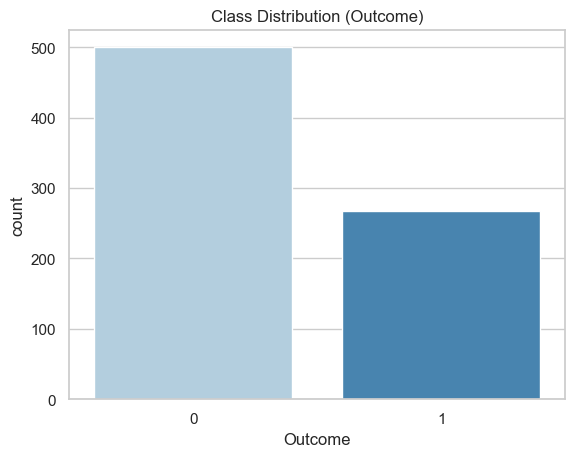
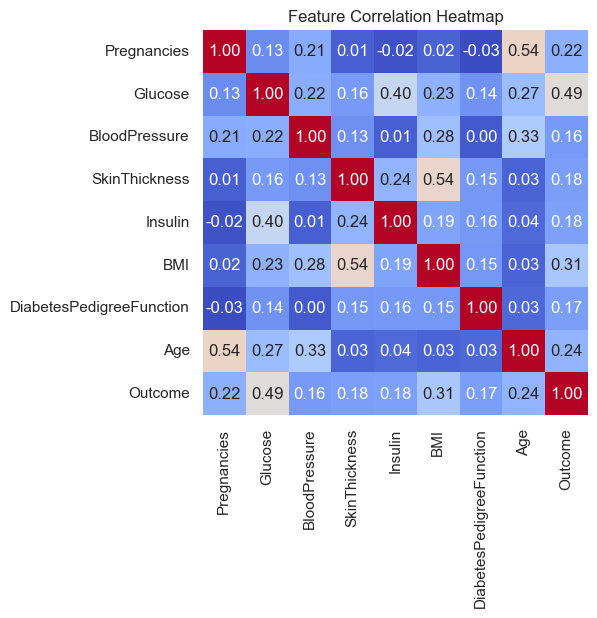
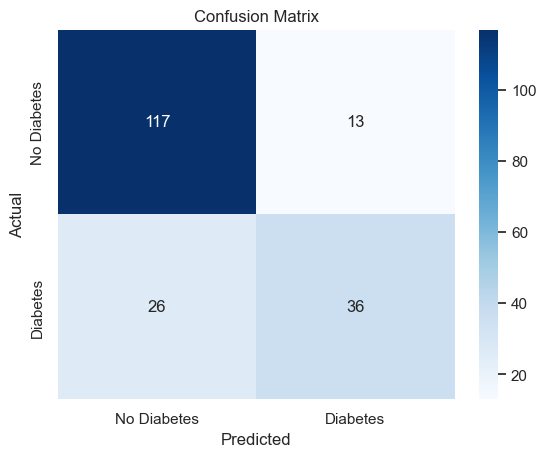
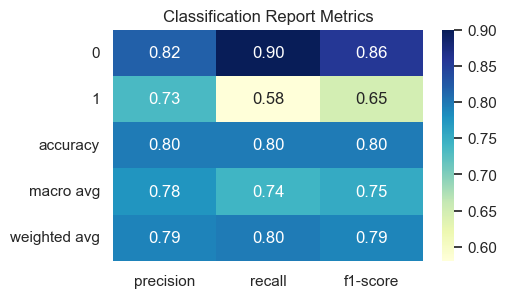
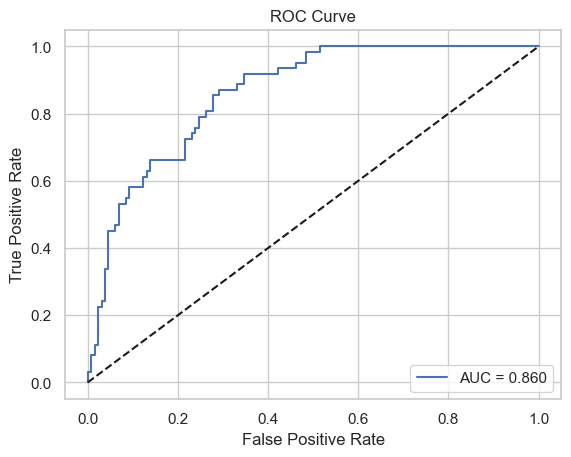
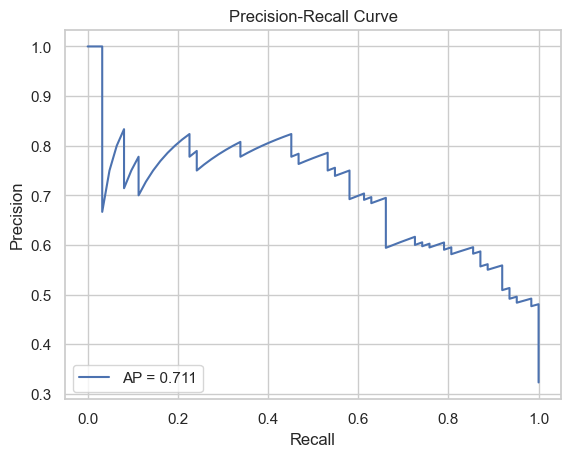
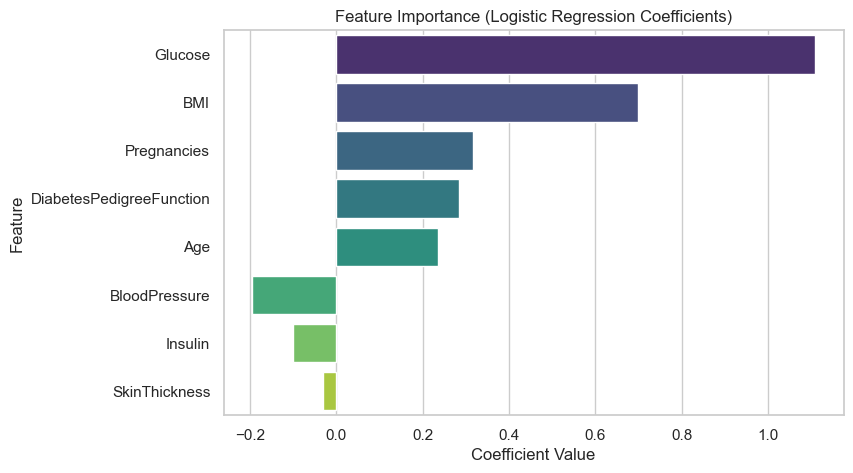

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from IPython.display import display, HTML
import base64
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Read data
data = pd.read_csv('./diabetes.csv')

# Fix zero values in columns where zero is invalid
cols_fix_zero = ['BMI', 'BloodPressure', 'Glucose', 'Insulin', 'SkinThickness']
for col in cols_fix_zero:
    data[col] = data[col].replace(0, data[col].mean())

X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

logreg = LogisticRegression(max_iter=500)
clf = GridSearchCV(logreg, param_grid=param_grid, scoring='accuracy', cv=10)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
feature_names = X.columns
coefs = clf.best_estimator_.coef_[0]

# Function to convert plot to base64 image to display inline
def plot_to_base64(fig):
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    return img_base64

# Create each plot and convert to base64 images

plots = {}

# 1. Class distribution
fig, ax = plt.subplots()
sns.countplot(x='Outcome', data=data, palette='Blues', ax=ax)
ax.set_title('Class Distribution (Outcome)')
plots['Class Distribution'] = plot_to_base64(fig)

# 2. Correlation heatmap
fig, ax = plt.subplots(figsize=(6,5))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar=False, ax=ax)
ax.set_title('Feature Correlation Heatmap')
plots['Feature Correlation'] = plot_to_base64(fig)

# 3. Confusion matrix heatmap
fig, ax = plt.subplots()
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'], ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plots['Confusion Matrix'] = plot_to_base64(fig)

# 4. Classification report heatmap
fig, ax = plt.subplots(figsize=(5,3))
metrics_df = pd.DataFrame(class_report).iloc[:-1, :].T  # drop accuracy row, transpose
sns.heatmap(metrics_df[['precision', 'recall', 'f1-score']], annot=True, cmap='YlGnBu', fmt=".2f", ax=ax)
ax.set_title('Classification Report Metrics')
plots['Classification Report'] = plot_to_base64(fig)

# 5. ROC curve
fig, ax = plt.subplots()
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
ax.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
ax.plot([0,1], [0,1], 'k--')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plots['ROC Curve'] = plot_to_base64(fig)

# 6. Precision-Recall curve
fig, ax = plt.subplots()
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)
ax.plot(recall_vals, precision_vals, label=f'AP = {ap_score:.3f}')
ax.set_title('Precision-Recall Curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='lower left')
plots['Precision-Recall Curve'] = plot_to_base64(fig)

# 7. Feature importance
fig, ax = plt.subplots(figsize=(8,5))
feat_imp = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis', ax=ax)
ax.set_title('Feature Importance (Logistic Regression Coefficients)')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Feature')
plots['Feature Importance'] = plot_to_base64(fig)


# Display images in blocks with HTML (with common heading "For Diabetes")
html_str = '<div style="display:flex; flex-wrap: wrap; gap: 20px;">'

for title, img in plots.items():
    html_str += f'''
    <div style="border:1px solid #ddd; padding:10px; border-radius:8px; width:400px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <h2 style="text-align:center; font-family:sans-serif; color:#27ae60; margin-bottom:5px;">For Diabetes</h2>
        <h3 style="text-align:center; font-family:sans-serif; color:#2c3e50;">{title}</h3>
        <img src="data:image/png;base64,{img}" style="max-width:100%; border-radius:5px;" />
    </div>
    '''

html_str += '</div>'

display(HTML(html_str))


In [2]:
# Dataset Description
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
#here few misconception is there lke BMI can not be zero, BP can't be zero, glucose, insuline can't be zero so lets try to fix it
# now replacing zero values with the mean of the column
data['BMI'] = data['BMI'].replace(0,data['BMI'].mean())
data['BloodPressure'] = data['BloodPressure'].replace(0,data['BloodPressure'].mean())
data['Glucose'] = data['Glucose'].replace(0,data['Glucose'].mean())
data['Insulin'] = data['Insulin'].replace(0,data['Insulin'].mean())
data['SkinThickness'] = data['SkinThickness'].replace(0,data['SkinThickness'].mean())

In [5]:
#segregate the dependent and independent variable
X = data.drop(columns = ['Outcome'])
y = data['Outcome']

# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)


##standard Scaling- Standardization
def scaler_standard(X_train, X_test):
    #scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
   
    
    return X_train_scaled, X_test_scaled


X_train_scaled, X_test_scaled = scaler_standard(X_train, X_test)
X_train_scaled

array([[ 1.50755225, -1.09947934, -0.89942504, ..., -1.45561965,
        -0.98325882, -0.04863985],
       [-0.82986389, -0.1331471 , -1.23618124, ...,  0.09272955,
        -0.62493647, -0.88246592],
       [-1.12204091, -1.03283573,  0.61597784, ..., -0.03629955,
         0.39884168, -0.5489355 ],
       ...,
       [ 0.04666716, -0.93287033, -0.64685789, ..., -1.14021518,
        -0.96519215, -1.04923114],
       [ 2.09190629, -1.23276654,  0.11084355, ..., -0.36604058,
        -0.5075031 ,  0.11812536],
       [ 0.33884418,  0.46664532,  0.78435594, ..., -0.09470985,
         0.51627505,  2.953134  ]], shape=(576, 8))

In [6]:
log_reg = LogisticRegression()

log_reg.fit(X_train_scaled,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [7]:
## Hyperparameter Tuning
## GridSearch CV
from sklearn.model_selection import GridSearchCV
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [9]:
logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

clf.fit(X_train_scaled,y_train)

,estimator,LogisticRegression()
,param_grid,"{'C': array([1.e-03...e+02, 1.e+03]), 'penalty': ['l1', 'l2'], 'solver': ['newton-cg', 'lbfgs', ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [10]:
y_pred = clf.predict(X_test_scaled)

In [11]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[117,  13],
       [ 26,  36]])

In [12]:
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]

In [13]:
Precision = true_positive/(true_positive+false_positive)
Precision

np.float64(0.9)

In [14]:
Recall = true_positive/(true_positive+false_negative)
Recall

np.float64(0.8181818181818182)

In [15]:
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

np.float64(0.8571428571428572)

In [17]:
#saving the model
import pickle

# Saving the model as chilll.pkl
with open('chilll.pkl', 'wb') as file:
    pickle.dump(log_reg, file)
